### 파이토치 MNIST 모델

##### modules import

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')

##### 전처리 설정
- `transform.Compose`

In [36]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

##### 데이터 로드 및 데이터 확인

In [37]:
trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

testset = torchvision.datasets.MNIST(root='./data',
                                      train=False,
                                      download=True,
                                      transform=transform)

In [38]:
train_loader = DataLoader(trainset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(testset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=2)

In [39]:
image, label = next(iter(train_loader))

In [40]:
image.shape, label.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [41]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    fig = plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

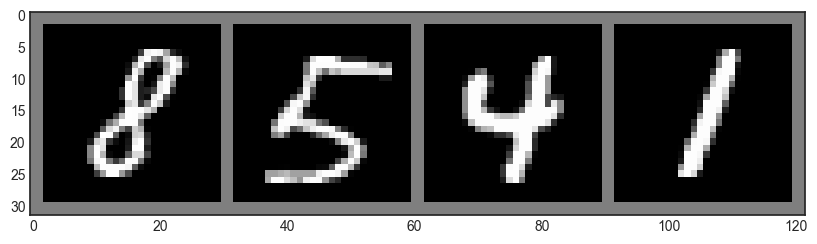

In [42]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))

##### 신경망 구성

In [43]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        # image = H, W, C (H : Hight, W : Width, C : Channel)
        # image shape = 28 * 28 * 1
        self.conv1 = nn.Conv2d(1, 6, 3) # 26 * 26 -> 13 * 13
        self.conv2 = nn.Conv2d(6, 16, 3) # 11 * 11 -> 5 * 5
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
            
        return num_features
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


- `parameters()`

In [44]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 3, 3])


임의의 값을 넣어 forward값 확인

In [45]:
input = torch.randn(1, 1, 28, 28)
out = net(input)
print(out)

tensor([[ 0.0382,  0.0140,  0.0064,  0.0029, -0.1189,  0.0945, -0.1197,  0.1197,
          0.1024, -0.0254]], grad_fn=<AddmmBackward0>)


In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

##### 모델 학습
- `optimer.zero_grad` : 가중치의 그래티언트 초기화
- loss 계산
- loss.backward()
- optimizer.step() : 업데이트

- 배치 수 확인

In [47]:
total_batch = len(train_loader)
print(total_batch)

469


- 설명을 위해 `epoch=2`로 지정

In [48]:
# for epoch in range(2):
#     running_loss = 0.0
#     for i, data in enumerate(train_loader, 0):
#         inputs, labels = data
        
#         optimizer.zero_grad()
        
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
#         if i % 100 == 99:
#             avg_loss = running_loss / (100 * 128)
#             print(f"Epoch: {epoch+1}, Iter: {i+1}, Loss: {avg_loss}")
#             running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.01800626153126359
Epoch: 1, Iter: 200, Loss: 0.017966814097017048
Epoch: 1, Iter: 300, Loss: 0.017936429493129253
Epoch: 1, Iter: 400, Loss: 0.01789722254499793
Epoch: 2, Iter: 100, Loss: 0.017800715658813714
Epoch: 2, Iter: 200, Loss: 0.017701205164194107
Epoch: 2, Iter: 300, Loss: 0.017540550101548435
Epoch: 2, Iter: 400, Loss: 0.017172845248132944


##### 모델의 저장 및 로드
- `torch.save`
    - `net.state_dict()`를 저장
- `torch.load`
    - `load_state_dict`로 모델을 로드

In [49]:
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)

In [50]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [51]:
net.parameters

<bound method Module.parameters of Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)>

##### 모델 테스트

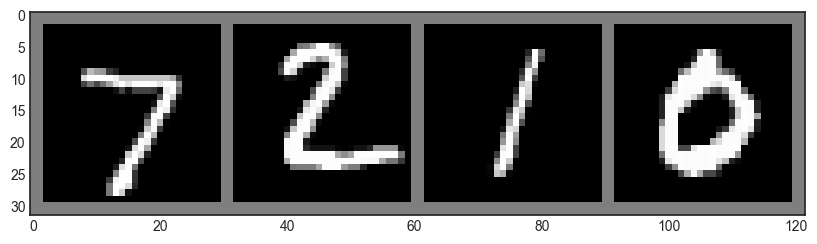

In [52]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

In [53]:
outputs = net(images)

In [54]:
labels

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2,
        5, 4, 7, 6, 7, 9, 0, 5])

In [55]:
print(outputs.data)
print()
print(outputs[0])
print()
a, b = torch.max(outputs[:3], dim=1)
print(torch.max(outputs[:3], dim=1))
print()
print(a)
print(b)

tensor([[-2.8252e-01,  2.5231e-01, -2.3220e-01,  ...,  4.6191e-01,
         -3.8197e-01,  2.5922e-01],
        [ 1.5934e-01,  3.0761e-02,  3.0118e-01,  ..., -3.9902e-01,
          2.4473e-01, -3.8035e-01],
        [-4.9620e-01,  7.0726e-01, -2.2509e-02,  ...,  2.7191e-01,
         -2.7436e-01,  7.6596e-02],
        ...,
        [-3.7682e-01,  2.7048e-01, -1.0374e-01,  ...,  2.8892e-01,
         -3.3087e-01,  2.1775e-01],
        [ 1.7100e-01,  4.4583e-04,  1.4227e-01,  ..., -5.9006e-02,
         -3.1767e-02, -2.2393e-01],
        [-1.1313e-01,  1.3992e-01, -2.4629e-01,  ...,  1.9310e-01,
         -1.6996e-01,  1.3916e-01]])

tensor([-0.2825,  0.2523, -0.2322, -0.1059,  0.1508, -0.2210, -0.1422,  0.4619,
        -0.3820,  0.2592], grad_fn=<SelectBackward0>)

torch.return_types.max(
values=tensor([0.4619, 0.4735, 0.7073], grad_fn=<MaxBackward0>),
indices=tensor([7, 3, 1]))

tensor([0.4619, 0.4735, 0.7073], grad_fn=<MaxBackward0>)
tensor([7, 3, 1])


In [56]:
_, predicted = torch.max(outputs, dim=1)
print(predicted)

tensor([7, 3, 1, 0, 7, 1, 7, 7, 6, 7, 3, 3, 7, 3, 1, 3, 7, 7, 3, 7, 7, 3, 1, 1,
        7, 0, 7, 7, 3, 1, 3, 1, 3, 6, 1, 3, 7, 1, 3, 1, 1, 7, 7, 1, 1, 3, 1, 1,
        9, 7, 6, 3, 7, 3, 1, 3, 7, 1, 7, 1, 7, 8, 1, 1, 7, 1, 7, 7, 3, 0, 7, 0,
        3, 1, 1, 7, 3, 7, 1, 7, 7, 6, 2, 7, 7, 9, 7, 3, 7, 1, 3, 1, 1, 3, 1, 7,
        1, 1, 6, 7, 1, 0, 7, 4, 7, 7, 3, 1, 7, 7, 3, 1, 1, 7, 1, 1, 7, 7, 7, 7,
        3, 7, 7, 6, 7, 7, 3, 7])


In [57]:
print(''.join(f'{predicted[j].numpy()}\t' for j in range(4)))

7	3	1	0	


In [58]:
correct = 0
total = 0
total = len(test_loader.dataset)

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        # print(labels.size(0))
        # total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(100 * correct / total)

43.01


##### GPU 설정 후 학습
- 설정 후, 모델과 데이터에 `to`로 GPU를 사용 가능한 혀태로 변환 해줘야 한다.
- `.cuda()`로도 가능

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')

- 현재 GPU 설정

In [60]:
torch.cuda.is_available()

True

In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

- 데이터 로드

In [62]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

In [63]:
trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

testset = torchvision.datasets.MNIST(root='./data',
                                      train=False,
                                      download=True,
                                      transform=transform)

In [64]:
train_loader = DataLoader(trainset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(testset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=2)

- 모델 생성

In [65]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        # image = H, W, C (H : Hight, W : Width, C : Channel)
        # image shape = 28 * 28 * 1
        self.conv1 = nn.Conv2d(1, 6, 3) # 26 * 26 -> 13 * 13
        self.conv2 = nn.Conv2d(6, 16, 3) # 11 * 11 -> 5 * 5
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
            
        return num_features
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [66]:
from torchsummary import summary

net = Net().to(device)
summary(net, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              60
            Conv2d-2           [-1, 16, 11, 11]             880
            Linear-3                  [-1, 120]          48,120
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 60,074
Trainable params: 60,074
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.23
Estimated Total Size (MB): 0.28
----------------------------------------------------------------


In [67]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [68]:
for epoch in range(50):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:
            avg_loss = running_loss / (100 * 128)
            print(f"Epoch: {epoch+1}, Iter: {i+1}, Loss: {avg_loss}")
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.01799313450232148
Epoch: 1, Iter: 200, Loss: 0.017931359745562078
Epoch: 1, Iter: 300, Loss: 0.01785078626126051
Epoch: 1, Iter: 400, Loss: 0.017726589646190404
Epoch: 2, Iter: 100, Loss: 0.017287509366869926
Epoch: 2, Iter: 200, Loss: 0.016505905454978348
Epoch: 2, Iter: 300, Loss: 0.014247912252321838
Epoch: 2, Iter: 400, Loss: 0.00938927116803825
Epoch: 3, Iter: 100, Loss: 0.004274890660308301
Epoch: 3, Iter: 200, Loss: 0.0034847347252070903
Epoch: 3, Iter: 300, Loss: 0.002961928655859083
Epoch: 3, Iter: 400, Loss: 0.002570789953460917
Epoch: 4, Iter: 100, Loss: 0.002359306865837425
Epoch: 4, Iter: 200, Loss: 0.002037226550746709
Epoch: 4, Iter: 300, Loss: 0.001944543969584629
Epoch: 4, Iter: 400, Loss: 0.0018920912087196484
Epoch: 5, Iter: 100, Loss: 0.0016716499062022195
Epoch: 5, Iter: 200, Loss: 0.0016673927981173619
Epoch: 5, Iter: 300, Loss: 0.0015186375874327496
Epoch: 5, Iter: 400, Loss: 0.0014853904285700992
Epoch: 6, Iter: 100, Loss: 0.00136329

In [70]:
correct = 0
total = 0
total = len(test_loader.dataset)

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        # print(labels.size(0))
        # total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(100 * correct / total)

98.86
